In [1]:
import jax
from jax import random, Array
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from typing import *

from gp import k, mk_cov, cholesky_inv, create_toy_sparse_dataset, PlotContext

key = random.PRNGKey(42)  # Create a random key

# KRR with Tikhonov Regularization

In this notebook, we'll introduce KRR with **Tikhonov regularization**. Similar to how a KRR was related to a GP regression, a KRR with Tikhonov regularization will be related to the SoR sparse GP model. We reintroduce our toy dataset from before below.

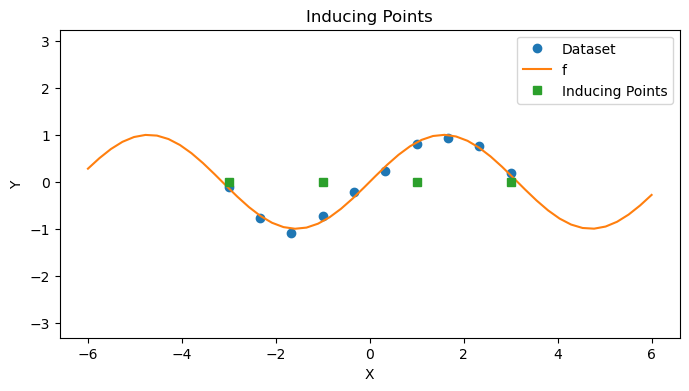

In [2]:
# Create dataset
f = lambda x: jnp.sin(x)
xs, zs, ys, Sigma = create_toy_sparse_dataset(f, key)
N, M = len(xs), len(zs)

# Plot
with PlotContext(title="Inducing Points", xlabel="X", ylabel="Y") as ax:
    plt.plot(xs, ys, marker="o", linestyle="None", label="Dataset")
    plt.plot(jnp.linspace(-6, 6), f(jnp.linspace(-6, 6)), label="f")
    plt.plot(zs, jnp.zeros_like(zs), marker="s", linestyle="None", label="Inducing Points")

## KRR with Tikhonov Regularization

Like a sparse GP based on inducing points, a KRR with Tikhonov regularization is parameterized by $M$ inducing points $z = (z_1 \dots z_m)^T$. The predictive function is given as

$$
krr(x_*; z, \alpha) = K_{*z} \alpha
$$

where
- $K_{x_* z} = (k(x_*, z_1) \dots k(x_*, z_M))^T$ is the kernel between an input and an inducing point and
- $\alpha$ is a vector of $M$ weights that is learned.
For comparison, an ordinary KRR has predictive function $krr(x_*; \alpha) = K_{*x} \alpha$ where $x = (x_1 \dots x_N)^T$ are the inputs in the dataset.

In [3]:
def krr(k: Callable, zs: Array, alpha: Array, x_star: Array) -> Array:
    """Kernel ridge regression with Tikhonov regularization
    """
    K_star_u = mk_cov(k, x_star, zs).reshape(-1)
    return K_star_u @ alpha

### Learning the Weights: Loss Function

Given a dataset $\mathcal{D} = \{(x_i, y_i) \}_{1 \leq i \leq N}$, the weights of a KRR $\alpha$ with Tikhonov regularization are choosen to minimize the loss function

$$
\mathcal{L}(\alpha; \mathcal{D}) = (y - K_{fu}\alpha)^T\Sigma^{-1}(y - K_{fu}\alpha) + \alpha^T K_{uu} \alpha \,.
$$

(see Appendix: Checking Loss Minimization). The term $\alpha^T K_{uu} \alpha$ performs **Tikhonov regularization**.

    - The weights are given by are given by

$$
\alpha = (K_{uf}\Sigma^{-1}K_{fu} + K_{uu})^{-1}K_{uf}\Sigma^{-1}y
$$

    and can be obtained by minimizing $\mathcal{L}(\alpha; \mathcal{D})$ with respect to $\alpha$ (See Appendix: KRR with Tikhonov Regularization).
    - Note that this agrees with the mean of the test point prediction from a probabilistic view of a GP since the prediction

$$
krr(x_*) = K_{*u}\alpha = K_{*u}(K_{uf}\Sigma^{-1}K_{fu} + K_{uu})^{-1}K_{uf}\Sigma^{-1}y
$$

    is the mean of $p(f_* | y)$.
    - The term $\alpha^T K_{uu} \alpha$ is a **regularization term** that performs **$\ell^2$ regularization**.
    - The weights correspond to a **weight-space view** of GPs.

In [4]:
def loss_tk(k: Callable, Sigma: Array, xs: Array, ys: Array, zs: Array, K_uu: Array, K_uf: Array, alpha: Array) -> float:
    """Loss function.
    """
    # diff = ys.flatten() - K_uf.transpose() @ alpha
    diff = ys.flatten() - jax.vmap(lambda x: krr(k, zs, alpha, x))(xs)
    return diff.transpose() @ cholesky_inv(Sigma) @ diff + alpha.transpose() @ K_uu @ alpha

### Learning the Weights: Solution

The minimum can be solved in closed form and is given by

$$
\alpha = (K_{uf}\Sigma^{-1}K_{fu} + K_{uu})^{-1}K_{uf}\Sigma^{-1}y
$$

and can be obtained by minimizing $\mathcal{L}(\alpha; \mathcal{D})$ with respect to $\alpha$ (See Appendix: KRR with Tikhonov Regularization).
Note that this agrees with the mean of the test point prediction from a SoR GP since the prediction

$$
krr(x_*) = K_{*u}\alpha = K_{*u}(K_{uf}\Sigma^{-1}K_{fu} + K_{uu})^{-1}K_{uf}\Sigma^{-1}y
$$

is the mean of $q_{SoR}(f_* | y)$.

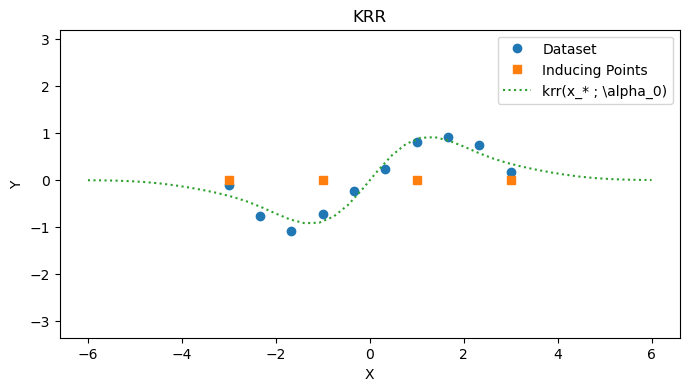

In [5]:
# Calculate solution
K_uu = mk_cov(k, zs, zs)
K_uf = mk_cov(k, zs, xs)
Sigma_inv = cholesky_inv(Sigma)
alpha_star = cholesky_inv(K_uu + K_uf @ Sigma_inv @ K_uf.transpose()) @ K_uf @ Sigma_inv @ ys

with PlotContext(title="KRR", xlabel="X", ylabel="Y") as ax:
    # Plot dataset
    plt.plot(xs, ys, marker="o", linestyle="None", label="Dataset")
    plt.plot(zs, jnp.zeros_like(zs), marker="s", linestyle="None", label="Inducing Points")

    # Plot KRR
    test_xs = jnp.linspace(-6, 6, 40).reshape(-1, 1)
    plt.plot(test_xs, [krr(k, zs, alpha_star, x) for x in test_xs], label=r"krr(x_* ; \alpha_0)", linestyle="dotted")

## Tikhonov regularization reduces to KRR when x = z

Suppose $K = K_{uu} = K_{uf} = K_{fu} = K_{ff}$. Then

\begin{align*}
-K_{uf}\Sigma^{-1}y + K_{uf}\Sigma^{-1}K_{fu}\alpha + K_{uu}\alpha = 0 & \iff -K\Sigma^{-1}y + K\Sigma^{-1}K\alpha + K\alpha = 0 \tag{assumption} \\
& \iff - y + K\alpha + \Sigma\alpha = 0 \tag{multiply by $\Sigma K^{-1}$}\\
& \iff \alpha = (K + \Sigma)^{-1}y \tag{solve for $\alpha$}
\end{align*}

This agrees with standard GP prediction.

## Summary

1. Introduced KRR with Tikhonov regularization, a closely related model to SoR GP regression.
2. Illustrated KRR with Tikhonov regularization on a toy dataset.

### Appendix: KRR with Tikhonov Regularization

We can check that the minima of 

$$
\mathcal{L}(\alpha; \mathcal{D}) = (y - K_{fu}\alpha)^T \Sigma^{-1} (y - K_{fu}\alpha) + \alpha^T K_{uu} \alpha
$$

with respect to the KRR model is

$$
\alpha = (K_{uf}\Sigma^{-1}K_{fu} + K_{uu})^{-1}K_{uf}\Sigma^{-1}y \,.
$$

We can compute
\begin{align*}
\operatorname{argmin}_\alpha \mathcal{L}(\alpha; \mathcal{D}) & \iff \nabla_{\alpha^T} \mathcal{L}(\alpha; \mathcal{D}) = 0 \tag{convex} \\
& \iff -K_{uf}\Sigma^{-1}y + K_{uf}\Sigma^{-1}K_{fu}\alpha + K_{uu}\alpha = 0 \tag{gradient} \\
& \iff K_{uf}\Sigma^{-1}y = (K_{uf}\Sigma^{-1}K_{fu} + K_{uu})\alpha = 0 \tag{rearrange} \\
& \iff \alpha = (K_{uf}\Sigma^{-1}K_{fu} + K_{uu})^{-1}K_{uf}\Sigma^{-1}y \tag{solve for $\alpha$} \\
\end{align*}

### Appendix: KRR via Loss Minimization

In [6]:
def grad_desc_tk(loss: Callable, k: Array, Sigma: Array, xs: Array, ys: Array,
                 zs: Array, K_uu: Array, K_uf: Array, alpha_0, lr=0.00001, iterations=100):
    """Simple gradient descent procedure to optimize loss function.
    """
    pbar = tqdm(range(iterations))
    losses = []
    for i in pbar:
        step = lr * jax.jacrev(loss, argnums=7)(k, Sigma, xs, ys, zs, K_uu, K_uf, alpha_0)
        alpha_0 = alpha_0 - step
        l = loss(k, Sigma, xs, ys, zs, K_uu, K_uf, alpha_0)
        losses += [l]
        pbar.set_postfix(loss=l)
    return alpha_0, losses

  0%|          | 0/500 [00:00<?, ?it/s]

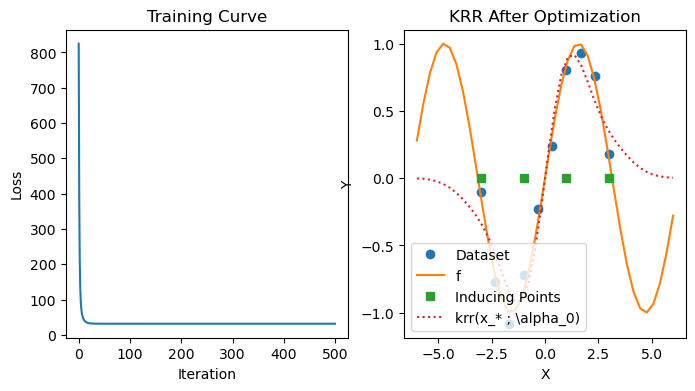

In [7]:
iterations = 500
alpha_star, losses = grad_desc_tk(loss_tk, k, Sigma, xs, ys, zs, K_uu, K_uf, jnp.ones(M), lr=0.0005, iterations=iterations)
    
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(range(iterations), losses)
plt.title("Training Curve"); plt.xlabel("Iteration"); plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(xs, ys, marker="o", linestyle="None", label="Dataset")
plt.plot(test_xs, [f(x) for x in test_xs], label="f")
plt.plot(zs, jnp.zeros_like(zs), marker="s", linestyle="None", label="Inducing Points")
plt.plot(test_xs, [krr(k, zs, alpha_star, x) for x in test_xs], label=r"krr(x_* ; \alpha_0)", linestyle="dotted")
plt.title("KRR After Optimization"); plt.xlabel("X"); plt.ylabel("Y"); plt.legend();